##### [CS138] Reinforcement Learning HW3: Cliff Walking With Temporal Difference Learning 
##### My Own Questions: The impact of Epsilon
##### Hye-jung Park

##### import libraries

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

##### Make a list of states for cliff walking (grid)

In [2]:
# Generate the state names and make a list of them 
# Since the cliff walking is on a grid, use a state name as form of coordinate (e.g. s_0_0, s_0_1) so that we know the location of each state in the grid based on the state name.
# The grid for cliff walking: 
    # Grid size: 4 x 12 
    #           (x-axis or horizontal: 0 ~ 3, y-axis or vertical: 0 ~ 11)
    # start state: s_0_0
    # terminal state: s_0_11 (reward: 0 or 1)
    # cliff: 
         # s_1_0, s_2_0, s_3_0, s_4_0, s_5_0, s_6_0, s_7_0, s_8_0, s_9_0, s_10_0
         # reward: -100
    # reward for all other state: -1  

state_names = []
for i in range(0, 4):
    for j in range(0, 12):
        s = 's' + '_' + str(j) + '_' + str(i)
        state_names.append(s) 

##### State As Class
##### Track each state's name, coordinate(vertical, horizontal), possible actions, next state, q value for each action. It also includes two functions: 1) updating Q(S, A) value for each action (for on-policy) 2) finding max q value for state-action pair (for off-policy)

In [3]:
# class State
class State():
    def __init__(self, name):
        self.name = name
        self.x = 0
        self.y = 0
        self.actions_q = {'up': 0, 'down': 0, 'right': 0, 'left': 0}
        self.next_state = {'up': 's_0_0', 'down': 's_0_0', 'right': 's_0_0', 'left': 's_0_0'}
        self.reward = {'up': 0, 'down': 0, 'right': 0, 'left': 0}

    
  # function to get the information on the coordinate (vertical, horizontal)
    def get_coordinate(self, name):
        coordinate = name.split('_')
        self.x = int(coordinate[1])
        self.y = int(coordinate[2])

  # This function takes action, and then returns the next state and reward.  

    def get_next_reward(self, action):
        # get next state and reward with the action

        # Case 1: for the terminal state
        if self.x == 11 and self.y == 0:
            self.next_state[action] = 'terminal'
            self.reward[action] = 0

        # Case 2: for start state with actions down or right
        elif self.x == 0 and self.y == 0 and action == 'down':
            self.next_state[action] = self.name
            self.reward[action] = -1
        
        elif self.x == 0 and self.y == 0 and action == 'left':
            self.next_state[action] = self.name
            self.reward[action] = -1
        
        elif self.x == 0 and self.y == 0 and action == 'right':
            self.next_state[action] = 's' + '_' + str(self.x + 1) + '_' + str(self.y)
            self.reward[action] = -100

        # Case 3: next is left wall, x = 0 and action = left (left wall)
        elif self.x == 0 and action == 'left':
            self.next_state[action] = self.name
            self.reward[action] = -1
        
        # Case 4: next is right wall, x = 11 and  1 <= y <=3 action = right 
        elif self.x == 11 and action == 'right' and self.y >= 1 and self.y <= 3:
            self.next_state[action] = self.name
            self.reward[action] = -1

        # Case 5: next is wall up, y = 3 action = up
        elif self.y == 3 and action == 'up':
            self.next_state[action] = self.name
            self.reward[action] = -1

        # Case 6: next is a cliff, y = 1 and 1 <= x <= 10 and action = 'down'
        elif self.y == 1 and action == 'down' and self.x >= 1 and self.x <= 10:
            reward = -100
            self.next_state[action] = 's_0_0'
            self.reward[action] = -100

        # Case 7: cliff sate itself 1 <= x <= 10, y = 0
        elif self.y == 0 and self.x >= 1 and self.x <= 10:
            self.next_state[action] = 's_0_0'
            self.reward[action] = -1
 
        # All other cases
        else:
            if action == 'up':
                self.next_state[action] = 's' + '_' + str(self.x) + '_' + str(self.y + 1)
                self.reward[action] = -1
            
            if action == 'down':
                self.next_state[action] = 's' + '_' + str(self.x) + '_' + str(self.y - 1)
                self.reward[action] = -1
            
            if action == 'right':
                self.next_state[action] = 's' + '_' + str(self.x + 1) + '_' + str(self.y)
                self.reward[action] = -1
            
            if action == 'left':
                self.next_state[action] = 's' + '_' + str(self.x - 1) + '_' + str(self.y)
                self.reward[action] = -1
    
    # This function takes an epsilon, alpha, gamma values and an action. It then choose an action based on an epsilon greedy policy and returns: 1) the state as a class itself 2) the action choosen 3) the current q value for the station-action pair.

    def e_greedy(self, epsilon=0.1):

        random_n = random.uniform(0, 100)
        if random_n <= epsilon * 100:
            action_list = ['up', 'down', 'right', 'left']
            action_choice = random.choice(action_list)

        else:
            max_q = max(self.actions_q.values())
            max_q_list = []
            for key, value in self.actions_q.items():
                if value == max_q:
                    max_q_list.append(key)

            if len(max_q_list) == 1:
                action_choice = max_q_list[0]
            if len(max_q_list) > 1:
                action_choice = random.choice(max_q_list)
        
        current_q = self.actions_q[action_choice]
        
        return self, action_choice, current_q 
            
            
    # This function gives you the action whose q value of the state-action pair has the max value among others. If there is a tie, use a tie breaker. It then returns: 1) the state as a class itself 2) the action whose current q value is the max 2) the q value of state-action pair.

    def max_q(self):
        max_q = max(self.actions_q.values())
        max_q_list = []
        for key, value in self.actions_q.items():
            if value == max_q:
                max_q_list.append(key)

        if len(max_q_list) == 1:
            action_choice = max_q_list[0]
        if len(max_q_list) > 1:
            action_choice = random.choice(max_q_list)
    
        current_q = self.actions_q[action_choice]

        return self, action_choice, current_q 

    # This function take alpha, gamma values and the q value of next state-action pair (for sarsa: use epsilon greedy function to get the next state-action pair in the class; for q-learning: use max-q function in the class). It then returns and updates the q value of the chosen state-action pair using Sarsa
    def learning(self, alpha=0.5, gamma=1, action='up', current_q=0, next_q=0):
        r = self.reward[action]
        new_q = current_q + (alpha * (r + (gamma * next_q) - current_q))
        self.actions_q[action] = new_q

        return r

##### Functions that find a path and the sum of rewards using Sarsa and Q-Learning

In [4]:
# SARSA

# This function takes a number of episode to experiment and epsilon values to use for the current state and the next state. It then uses a Sarsa learning, updates Q values for each state-action pair, and returns updated states and a list of sum of rewards eanred from each episode.
 
def sarsa_learning(num_episode=100, epsilon1 = 0.1, epsilon2=0.1):

    state_names = []
    for i in range(0, 4):
        for j in range(0, 12):
            s = 's' + '_' + str(j) + '_' + str(i)
            state_names.append(s) 

    state_classes = []
    for s in state_names:
        # Build a class for each state name 
        state = State(s)
        # Class function, get coordinate and update it in the class
        state.get_coordinate(s)
        # Class function to get next state and reward per action
        for action in state.actions_q.keys():
            state.get_next_reward(action)

        state_classes.append(state)

    # Get a sum of reward eared from the learning process of each episode and make a list of the sum of episodes. 
    rewards_list = []
    for i in range(num_episode):
        reward_sum = 0
        s = state_classes[0]
        next_state_name = s.name
        count = 0
        while next_state_name != 's_11_0':
            state1, action_choice1, current_q1 = s.e_greedy(epsilon=epsilon1)

            next_state_name = s.next_state[action_choice1]

            index = state_names.index(next_state_name)
            next_state = state_classes[index]
            state2, action_choice2, current_q2 = next_state.e_greedy(epsilon=epsilon2)

            r = s.learning(action=action_choice1, current_q=current_q1, next_q = current_q2)
            reward_sum += r
        
            s = next_state

            count += 1

        rewards_list.append(reward_sum)

    return state_names, state_classes, rewards_list

In [5]:
# Q-Learning

# This function takes a number of episode to experiment and epsilon values to use for current state and next state. It then uses a Q-learning, updates Q values for each state-action pair, and returns updated states and a list of sum of rewards eanred from each episode.

def q_learning(num_episode=100, state_names = [], state_classes = []):
  
    state_names = []
    for i in range(0, 4):
        for j in range(0, 12):
            s = 's' + '_' + str(j) + '_' + str(i)
            state_names.append(s) 

    state_classes = []
    for s in state_names:
        # Build a class for each state name 
        state = State(s)
        # Class function, get coordinate and update it in the class
        state.get_coordinate(s)
        # Class function to get next state and reward per action
        for action in state.actions_q.keys():
            state.get_next_reward(action)

        state_classes.append(state)

    # Get a sum of reward eared from the learning process of each episode and make a list of the sum of episodes. 
    rewards_list = []
    for i in range(num_episode):
        reward_sum = 0
        s = state_classes[0]
        next_state_name = s.name
        count = 0
        while next_state_name != 's_11_0':
            state1, action_choice1, current_q1 = s.e_greedy()

            next_state_name = s.next_state[action_choice1]

            index = state_names.index(next_state_name)
            next_state = state_classes[index]
            state2, action_choice2, current_q2 = next_state.max_q()

            
            r = s.learning(action=action_choice1, current_q=current_q1, next_q = current_q2)
            reward_sum += r
        
            s = next_state

            count += 1

        rewards_list.append(reward_sum)

    return state_names, state_classes, rewards_list

##### Printing the Path

In [6]:
# This function takes a list of state classes. It then prints the path and the sum of rewards; it also returns the path.

def print_path(state_classes=[]):
    path = []
    reward_sum = 0
    s = state_classes[0]
    next_state_name = s.name
    count = 0
    while s.name != 's_11_0':
        # print(f"state: {next_state_name}")
        max_q = max(s.actions_q.values())
        max_q_list = []
        for key, value in s.actions_q.items():
            if value == max_q:
                max_q_list.append(key)

        if len(max_q_list) == 1:
            optimal_action = max_q_list[0]
        if len(max_q_list) > 1:
            optimal_action = random.choice(max_q_list)

        # add the state to the path
        path.append(s.name)

        next_state_name = s.next_state[optimal_action]

        reward = s.reward[optimal_action]
        reward_sum += reward
        index = state_names.index(next_state_name)
        next_state = state_classes[index]
        s = next_state
    print(f"path: {path}")
    print(f"reward sum: {reward_sum}")
    return path

##### Function to print the cliff

In [7]:
# The function, print_cliff, takes a path (returned from the above print_path function) and visualizes the path on the grid for the cliff walking problem. 

cliff = ['s_1_0', 's_2_0', 's_3_0', 's_4_0', 's_5_0', 's_6_0', 's_7_0', 's_8_0', 's_9_0', 's_10_0']

def print_edge():
    for i in range(12):
        print("- - - ", end = "")
    # first line
    print("- ")

def print_cliff(path=[]):
    print_edge()
    for j in range(0, 4):
        for i in range(0, 12):
            x = "s" + "_" + str(i) + "_" + str(3-j)
            if x == 's_0_0':
                print("|", " ", end = "")
                print('S', " ",end = "")
            elif x == 's_11_0':
                print("|", " ", end = "")
                print('G', " ",end = "")
            elif x in cliff:
                print("|", " ", end = "")
                print('*', " ",end = "")
            elif x in path:
                print("|", " ", end = "")
                print('P', " ", end = "")
            else:
                print("|", " ", end = "")
                print(0, " ",end = "")
        print("|")
    print_edge()

##### Main Code

##### Sarsa: Experiment with different epsilon values

##### 1) epsilon for current state: 0.1; epsilon for next state: 0 

In [8]:
# Using a Sarsa learning, it finds a path for the cliff walking (# of episodes: 500, alpha: 0.5, epsilon for current state: 0.1, epsilon for next state: 0); prints the path, and visualizes the path on the grid for the cliff walking problem.

sn_s1, sc_s1, rs1= sarsa_learning(num_episode=500, epsilon1=0.1, epsilon2=0)

path_s1 = print_path(state_classes = sc_s1)
print_cliff(path_s1)

path: ['s_0_0', 's_0_1', 's_1_1', 's_2_1', 's_3_1', 's_4_1', 's_5_1', 's_6_1', 's_7_1', 's_8_1', 's_9_1', 's_10_1', 's_11_1']
reward sum: -13
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |
|  S  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  G  |
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [9]:
# Repeat 100 times and average
# 2d list of rewards of episodes for 100 different Sarsa-leadning results

rs_2d1 = []
rs_2d1.append(rs1)
for i in range(999):
    sn_s1_2, sc_s1_2, rs1_2 = sarsa_learning(num_episode=500, epsilon1=0.1, epsilon2=0)
    rs_2d1.append(rs1_2)

rs_2d_array1 = np.array(rs_2d1)

rs_2d_ave1 = np.average(rs_2d1, axis=0)

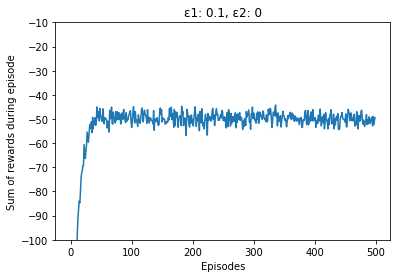

In [25]:
# plot: sum of episodes for Sarsa averaged with 100 results (num_episode=500, epsilon1=0.1, epsilon2=0)

plt.plot(rs_2d_ave1)
plt.ylim(-100, -10)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('ε1: 0.1, ε2: 0')
plt.show()

##### 2) Epsilon1: 0.1, Epsilon2: 0.1

In [11]:
# Using a Sarsa learning, it finds a path for the cliff walking (# of episodes: 500, alpha: 0.5, epsilon for both current state and next state: 0.1); prints the path, and visualizes the path on the grid for the cliff walking problem.

sn_s2, sc_s2, rs2= sarsa_learning(num_episode=500, epsilon1=0.1, epsilon2=0.1)

path_s2 = print_path(state_classes = sc_s2)
print_cliff(path_s2)

path: ['s_0_0', 's_0_1', 's_0_2', 's_0_3', 's_1_3', 's_2_3', 's_3_3', 's_4_3', 's_5_3', 's_6_3', 's_7_3', 's_8_3', 's_9_3', 's_10_3', 's_11_3', 's_11_2', 's_11_1']
reward sum: -17
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |
|  P  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  P  |
|  P  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  P  |
|  S  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  G  |
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [12]:
# Repeat 100 times and average
# 2d list of rewards of episodes for 100 different Sarsa-leadning results

rs_2d2 = []
rs_2d2.append(rs2)
for i in range(999):
    sn_s2_2, sc_s2_2, rs2_2 = sarsa_learning(num_episode=500, epsilon1=0.1, epsilon2=0.1)
    rs_2d2.append(rs2_2)

rs_2d_array2 = np.array(rs_2d2)

rs_2d_ave2 = np.average(rs_2d2, axis=0)

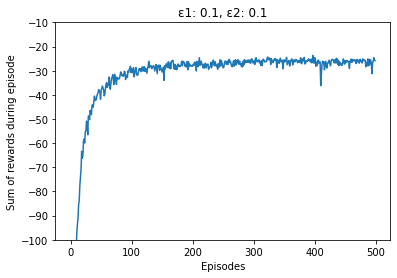

In [24]:
# plot: sum of episodes for Sarsa averaged with 100 results (# of episodes: 500, alpha: 0.5, epsilon for both current state and next state: 0.1)

plt.plot(rs_2d_ave2)
plt.ylim(-100, -10)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('ε1: 0.1, ε2: 0.1')
plt.show()

##### 3) Epsilon1: 0.1, Epsilon2: 0.01

In [22]:
# Using a Sarsa learning, it finds a path for the cliff walking (# of episodes: 500, alpha: 0.5, epsilon for the current state 0.1 and epsilon for next state: 0.01); prints the path, and visualizes the path on the grid for the cliff walking problem.

sn_s3, sc_s3, rs3= sarsa_learning(num_episode=500, epsilon1=0.1, epsilon2=0.01)

In [23]:
path_s3 = print_path(state_classes = sc_s3)
print_cliff(path_s3)

path: ['s_0_0', 's_0_1', 's_0_2', 's_1_2', 's_2_2', 's_3_2', 's_4_2', 's_5_2', 's_6_2', 's_7_2', 's_8_2', 's_9_2', 's_10_2', 's_11_2', 's_11_1']
reward sum: -15
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |
|  P  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  P  |
|  S  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  G  |
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [26]:
# Repeat 100 times and average
# 2d list of rewards of episodes for 100 different Sarsa-leadning results

rs_2d3 = []
rs_2d3.append(rs3)
for i in range(999):
    sn_s3_2, sc_s3_2, rs3_2 = sarsa_learning(num_episode=500, epsilon1=0.1, epsilon2=0.01)
    rs_2d3.append(rs3_2)

rs_2d_array3 = np.array(rs_2d3)

rs_2d_ave3 = np.average(rs_2d3, axis=0)

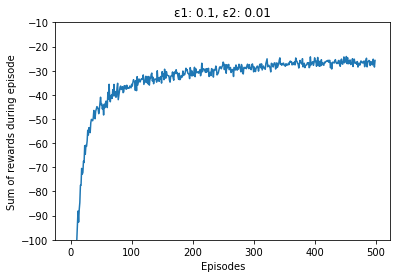

In [27]:
# plot: sum of episodes for Sarsa averaged with 100 results (# of episodes: 500, alpha: 0.5, epsilon for the current state: 0.1, epsilon for the next state: 0.01)

plt.plot(rs_2d_ave3)
plt.ylim(-100, -10)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('ε1: 0.1, ε2: 0.01')
plt.show()

##### 4) Epsilon1: 0.1, Epsilon2: 0.001

In [28]:
# Using a Sarsa learning, it finds a path for the cliff walking (# of episodes: 500, alpha: 0.5, epsilon for the current state 0.1 and epsilon for next state: 0.001); prints the path, and visualizes the path on the grid for the cliff walking problem.

sn_s4, sc_s4, rs4= sarsa_learning(num_episode=500, epsilon1=0.1, epsilon2=0.001)

In [29]:
path_s4 = print_path(state_classes = sc_s4)
print_cliff(path_s4)

path: ['s_0_0', 's_0_1', 's_1_1', 's_2_1', 's_3_1', 's_4_1', 's_5_1', 's_6_1', 's_7_1', 's_8_1', 's_9_1', 's_10_1', 's_11_1']
reward sum: -13
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |  P  |
|  S  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  *  |  G  |
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [30]:
# Repeat 100 times and average
# 2d list of rewards of episodes for 100 different Sarsa-leadning results

rs_2d4 = []
rs_2d4.append(rs4)
for i in range(999):
    sn_s4_2, sc_s4_2, rs4_2 = sarsa_learning(num_episode=500, epsilon1=0.1, epsilon2=0.001)
    rs_2d4.append(rs4_2)

rs_2d_array4 = np.array(rs_2d4)

rs_2d_ave4 = np.average(rs_2d4, axis=0)

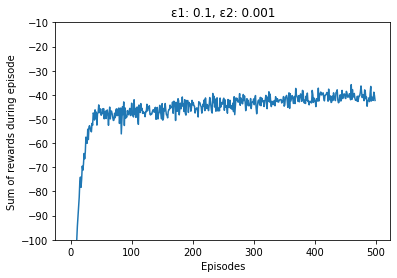

In [31]:
# plot: sum of episodes for Sarsa averaged with 100 results (# of episodes: 500, alpha: 0.5, epsilon for the current state: 0.1, epsilon for the next state: 0.001)

plt.plot(rs_2d_ave4)
plt.ylim(-100, -10)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('ε1: 0.1, ε2: 0.001')
plt.show()

##### Plotting sum of rewards during episode: Sarsa vs. Q-Learning (1 round with 500 episodes. Repeated 100 times. Averaged)

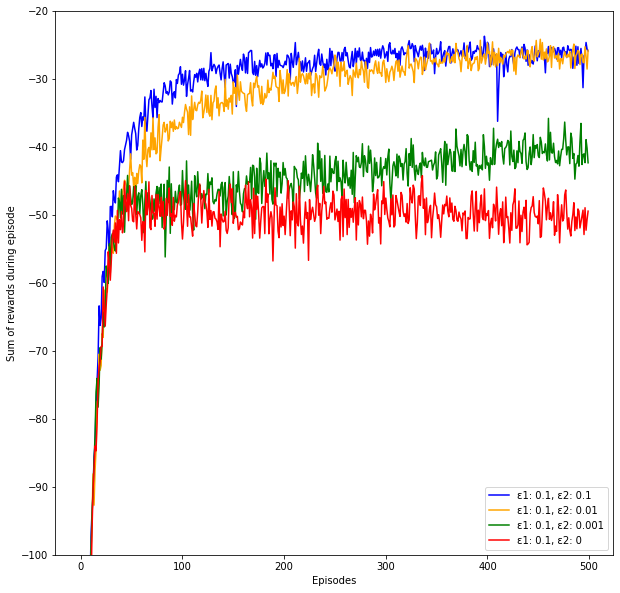

In [32]:
plt.figure(figsize=(10, 10))


plt.plot(rs_2d_ave2, color='blue', label='ε1: 0.1, ε2: 0.1')
plt.plot(rs_2d_ave3, color='orange', label='ε1: 0.1, ε2: 0.01')
plt.plot(rs_2d_ave4, color='green', label='ε1: 0.1, ε2: 0.001')
plt.plot(rs_2d_ave1, color='red', label='ε1: 0.1, ε2: 0')


plt.ylim(-100, -20)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend()
plt.show()